In [1]:
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def gen_seq_markov(alphabet, probs, seq_len):
    """ like sample_sequence_MM, but uses a numpy matrix, no start and end states, and a set sequence length
    """
    sequence = list(
        np.random.choice(alphabet, p=np.sum(probs, axis=0) / np.sum(probs), size=1)
    )
    for i in tqdm(range(seq_len)):
        sequence.append(np.random.choice(alphabet, p=probs[:, sequence[-1]], size=1)[0])
    return sequence

In [3]:
probs = np.array([[0.1, 0.9], [0.9, 0.1]])
alphabet = [0, 1]

In [4]:
sequence = gen_seq_markov(alphabet, probs, seq_len = 100000)

In [5]:
sequence[:10]

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [6]:
from childes_mi.information_theory import mutual_information as mi

In [7]:
distances = np.arange(1,101)

In [8]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    [sequence], distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.5s


[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


In [9]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [60]:
MI-shuff_MI

array([-4.72973727, -4.87608327, -4.95987259, -5.01109474, -5.04223782,
       -5.06205576, -5.07447269, -5.08245021, -5.08730128, -5.09076243,
       -5.09288405, -5.0941329 , -5.09506802, -5.09561168, -5.09604241,
       -5.09624558, -5.09637027, -5.09644368, -5.0965041 , -5.0965936 ,
       -5.09657208, -5.09661377, -5.09660497, -5.09661894, -5.09660621,
       -5.09662171, -5.09660424, -5.09660072, -5.0965939 , -5.09658709,
       -5.09661728, -5.09659852, -5.09657468, -5.09658757, -5.09657197,
       -5.09656132, -5.0965557 , -5.09656126, -5.09654764, -5.09653048,
       -5.09651483, -5.0965742 , -5.09655369, -5.09651675, -5.09652831,
       -5.09651561, -5.09651632, -5.09649925, -5.09650722, -5.09649883,
       -5.09648875, -5.096491  , -5.09647246, -5.09648232, -5.09648152,
       -5.09648108, -5.09646905, -5.09650292, -5.09645524, -5.09647242,
       -5.09644211, -5.09643635, -5.09643089, -5.09643075, -5.09642564,
       -5.09641915, -5.0964152 , -5.09643908, -5.09640553, -5.09

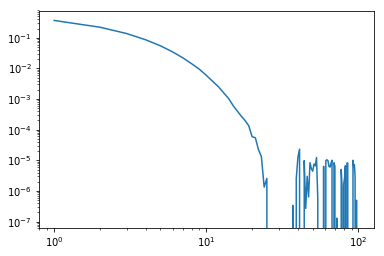

In [61]:
plt.loglog(row.distances, row.MI-row.shuff_MI)

In [10]:
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import matplotlib.pyplot as plt

In [62]:
nplot=50

In [63]:
row = MI_DF.iloc[0]

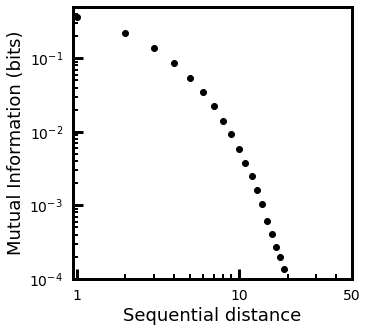

In [69]:
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
nplot=50
ax.scatter(distances[:nplot], MI[:nplot], color='k')
ax.fill_between(distances[:nplot], MI[:nplot]-MI_var[:nplot], MI[:nplot]+MI_var[:nplot], alpha = 0, color= 'k')
#ax.plot(mean_latent_distances[:nplot], MI[:nplot], alpha = 1, color= 'k', lw=5)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([1,50])

ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Mutual Information (bits)', fontsize=18)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ax.set_xticks([1,10,50])
ax.set_xticklabels(['1','10','50'])
ax.set_xlim([0.95,nplot])
ax.set_ylim([1e-4,.5])


ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())

In [70]:
import lmfit

In [71]:
def residuals(y_true, y_model, x, logscaled=False):
    if logscaled:
        return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
    else:
        return np.abs(y_true - y_model)

def model_res(p, x, y, fit, model):
    if fit == "lin":
        return residuals(y, model(p, x), x)
    else:
        return residuals(y, model(p, x), x, logscaled=True)
    
# fitting model
def fit_model_iter(model, n_iter=10, **kwargs):
    """ re-fit model n_iter times and choose the best fit
    chooses method based upon best-fit
    """
    models = []
    AICs = []
    for iter in np.arange(n_iter):
        results_model = model.minimize(**kwargs)
        models.append(results_model)
        AICs.append(results_model.aic)
    return models[np.argmin(AICs)]

def get_y(model, results, x):
    return model({i: results.params[i].value for i in results.params}, x)


def exp_decay(p, x):
    return p["e_init"] * np.exp(-x * p["e_decay_const"]) + p["intercept"]

# decay types
def powerlaw_decay(p, x):
    return p["p_init"] * x ** (p["p_decay_const"]) + p["intercept"]

p_exp = lmfit.Parameters()
p_exp.add_many(
    ("e_init", 0.5, True, 1e-10),
    ("e_decay_const", 0.1, True, 1e-10),
    ("intercept", 1e-5, True, 1e-10),
)

p_power = lmfit.Parameters()
p_power.add_many(
    ("p_init", 0.5, True, 1e-10),
    ("p_decay_const", -0.5, True, -np.inf, -1e-10),
    ("intercept", 1e-5, True, 1e-10),
)

In [72]:
fit='log'
n_iter=1
method=["nelder", "leastsq", "least-squares"]

In [73]:
d = distances[:nplot]
sig = MI[:nplot]

In [74]:

results_exp_min = lmfit.Minimizer(
    model_res, p_exp, fcn_args=(d, sig, fit, exp_decay), nan_policy="omit"
)

In [75]:
results_exp = [
    fit_model_iter(results_exp_min, n_iter=n_iter, **{"method": meth})
    for meth in method
]
results_exp = results_exp[np.argmin([i.aic for i in results_exp])]

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
results_exp

In [77]:
y_exp = get_y(exp_decay, results_exp, d)

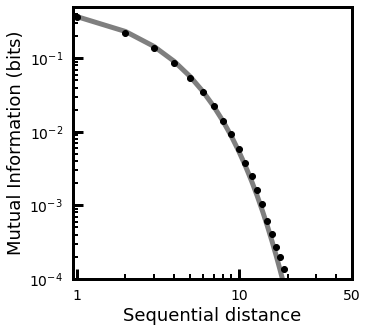

In [79]:
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
nplot=50
ax.scatter(distances[:nplot], MI[:nplot], color='k')
ax.fill_between(distances[:nplot], MI[:nplot]-MI_var[:nplot], MI[:nplot]+MI_var[:nplot], alpha = 0, color= 'k')
ax.plot(distances[:nplot], y_exp, alpha = 0.5, color= 'k', lw=5)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([1,50])

ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Mutual Information (bits)', fontsize=18)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ax.set_xticks([1,10,50])
ax.set_xticklabels(['1','10','50'])
ax.set_xlim([0.95,50])
ax.set_ylim([1e-4,.5])


ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())